<a href="https://colab.research.google.com/github/vdnghia03/Deep-Learning/blob/main/DL1_MLP_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## Multilayered perceptron (MLP) for image classification
---
 Note for MLP and its use in image classification task.

 Read more:
- [Sparse categorical cross-entropy keras - TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy?version=nightly)
- [Probabilistic machine learning draft pp. 419-444 - Murphy (2022)](https://probml.github.io/pml-book/book1.html)
- [Classification metrics in Keras - machinelearningmastery](https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/)
- [Softmax function - wikipedia](https://en.wikipedia.org/wiki/Softmax_function)
- [How many hidden layers/neurons - Gad (2018) towardsdatascience](https://towardsdatascience.com/beginners-ask-how-many-hidden-layers-neurons-to-use-in-artificial-neural-networks-51466afa0d3e)
- [Rule of thumb - Ranjan (2019) towardsdatascience](https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.datasets.mnist import load_data

plt.style.use("seaborn-v0_8-white")

In [2]:
(X_train, y_train), (X_test, y_test) = load_data("mnist.npz")
X_train.shape, X_test.shape, y_train.shape, y_test.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

### Normalize data
Need to scale the data so that gradient descent don't get vanishing or exploding gradients. We choose min-max normalization to get values between 0 and 1.

$$
X' = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$


In [3]:
print(X_train.min(), X_train.max())
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
print(X_train.min(), X_train.max())

0 255
0.0 1.0


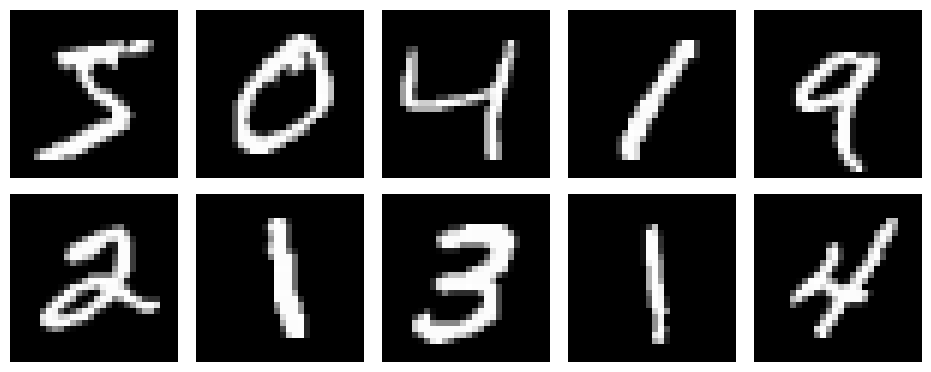

In [4]:
def display_images(data, nrows=2, ncols=5, figsize=(12,4)):
  fig, axes = plt.subplots(nrows, ncols, figsize = figsize)

  for i, ax in enumerate(axes.flatten()):
    ax.imshow(data[i,:,:], cmap = "gray")
    ax.axis("off")

  fig.subplots_adjust(wspace=0, hspace=.1, bottom=0)

display_images(X_train)



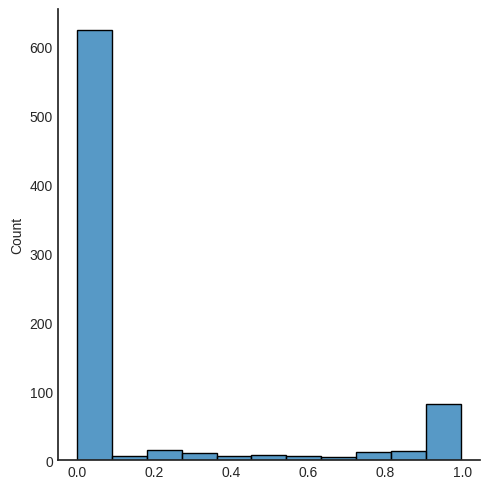

In [5]:
sns.displot(data=X_train[5000, :, :].reshape(-1), kind="hist", legend=True)

---
### Create MLP model
- 10 output nodes for 10 different classes
- softmax activation function in output layer for class probabilities
- sparse categorical cross-entropy loss function, when the number of classes in label >= 2
- categorical cross-entropy loss function, when number of classes in label >= 2 and it is one-hot encoded

#### Dropout layer
Randomly shuts off nodes to decrease overfitting

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

def MLP_model(nodes=None, names=None, activations=[]):
    model = Sequential(name="MLP_model")
    # flattens the input
    model.add(Flatten(input_shape=(28, 28), name="Input_layer"))

    for node, name, activation in zip(nodes, names, activations):
        model.add(Dense(node, name=name, activation=activation))

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy"])

    return model


model_naive = MLP_model(nodes=[10], names=["Output_layer"], activations=["softmax"])
model_naive.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "MLP_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model_naive.fit(X_train, y_train, validation_split=1/6, epochs=20, verbose=0)

In [9]:
naive_history = pd.DataFrame(model_naive.history.history)
naive_history.index = range(len(naive_history))
naive_history.head()

,accuracy,loss,val_accuracy,val_loss
0,0.86874,0.506115,0.9168,0.308396
1,0.91180,0.316432,0.9228,0.278908
2,0.91790,0.292373,0.9260,0.267261
3,0.92260,0.280385,0.9262,0.265091
4,0.92352,0.273432,0.9276,0.261424


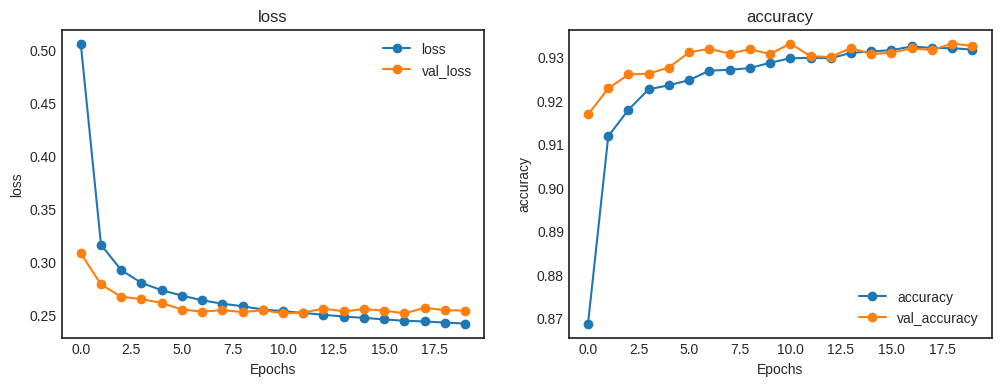

In [11]:
def plot_metric(df_history, style="-o"):
  fig, axes = plt.subplots(1,2, figsize=(12,4))
  metrics = [["loss", "val_loss"], ["accuracy", "val_accuracy"]]
  for ax, metric in zip(axes,metrics):
    df_history.plot(ax = ax
                    , y = metric
                    , xlabel = "Epochs"
                    , ylabel = metric[0]
                    , title = metric[0]
                    , style = style
                    , )

plot_metric(naive_history)

# Trong co ve no xa nhau nhung thuc te chung rat gan nhau

---
### Add hidden layers
- Use 2 hidden layers with 128 nodes each

In [12]:
model_deep = MLP_model(nodes = [128, 128, 10]
                       , activations = ["relu", "relu", "softmax"]
                       , names = ["Hidden_1", "Hidden_2", "Output"])
model_deep.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "MLP_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_1 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_2 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model_deep.fit(X_train, y_train, validation_split=1/6, verbose=0, epochs=20)


In [17]:
deep_history = pd.DataFrame(model_deep.history.history)
deep_history.index = range(len(deep_history))

deep_history.head()

,accuracy,loss,val_accuracy,val_loss
0,0.92544,0.251916,0.9618,0.131207
1,0.96770,0.105712,0.9696,0.102634
2,0.97596,0.074028,0.9736,0.088852
3,0.98248,0.055476,0.9745,0.088453
4,0.98588,0.044512,0.9728,0.094112


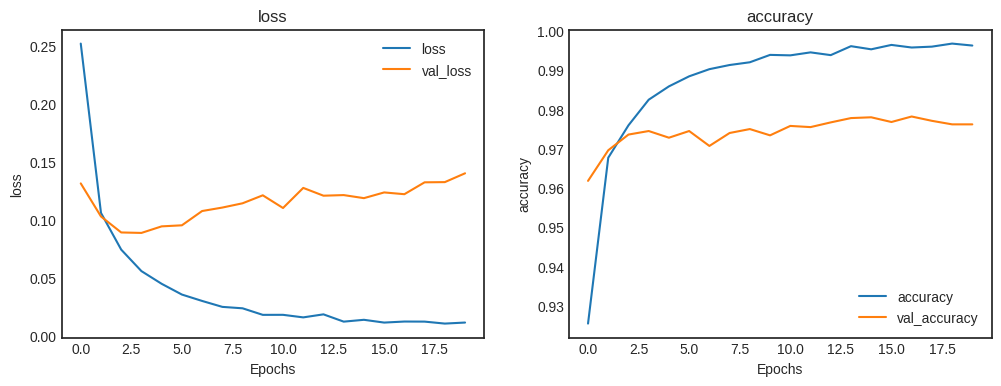

In [18]:
plot_metric(deep_history, style="-")

> - we see validation loss increases and overfits
>  - validation accuracy has stabilized, however in severe overfitting
>  - the model fits to a lot of noise in training data could lead to significant
 > - drop in validation accuracy


### Pick the model

  - we pick this model but chooses an early stopping and train for 8 epochs instead
  - not that now we train on all the training data, no splitting



In [19]:
model_deep.fit(X_train, y_train, epochs = 8, verbose=0)

---
### Prediction and evaluation


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.97      0.97       892
           6       0.99      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.95      0.98      0.97       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



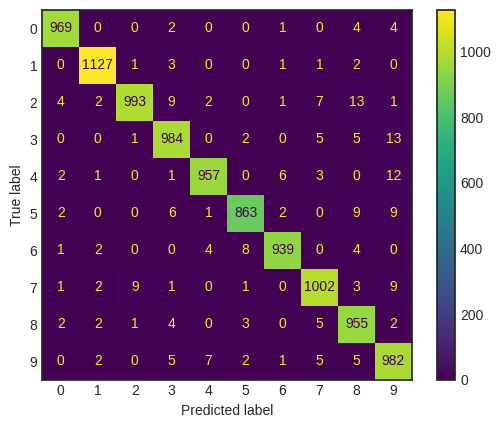

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model_deep.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)


print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()


---
### Display misclassifications


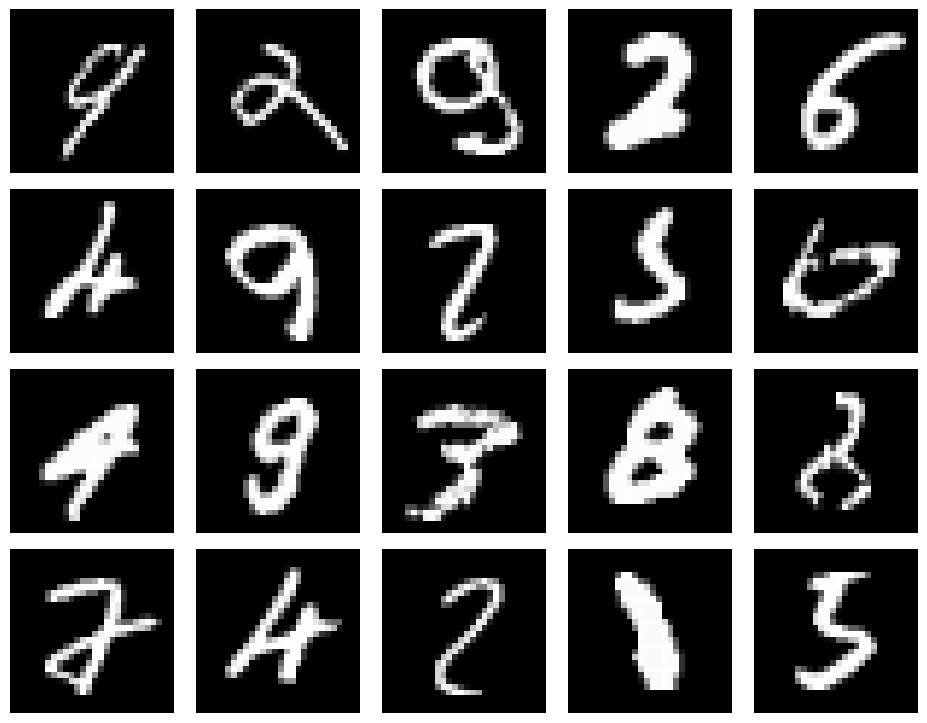

In [27]:
misclassified_indices = np.where(y_pred != y_test)[0]
misclassified_samples = X_test[misclassified_indices]

# a few misclassifications
display_images(misclassified_samples, 4,5, (12,8))
